<a href="https://colab.research.google.com/github/klausgottlieb/crut-monte-carlo-replication/blob/main/notebook_01_sensitivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 01 — Sensitivity Analysis
## *When Do Charitable Remainder Unitrusts Outperform? A Monte Carlo Analysis*
### Klaus Gottlieb, JD, MS, MBA — Wealth Care Lawyer, Cayucos, CA

---

## Purpose

This notebook replicates and extends the tornado sensitivity analysis reported in Figure 1 of the manuscript. It answers the question: **which input parameters most strongly influence CRUT outcomes, and in which direction?**

The analysis uses one-at-a-time (OAT) local sensitivity analysis — varying each parameter between a Low and High value while holding all others fixed at the baseline. This approach is standard in financial planning sensitivity analysis and produces the tornado diagram used in the manuscript.

**Important methodological note:** OAT sensitivity analysis captures the marginal effect of each parameter in isolation. It does not capture interactions between parameters — for example, the combined effect of low basis *and* long longevity, which is addressed in Notebooks 02 and 03. The OAT approach is chosen here for interpretability and comparability with prior practitioner literature.

**Baseline ground truth (from Notebook 00):**
- Win probability: **51.9%** [95% CI: 49.8%–54.1%]
- Median net benefit: **+$7,400**

**Figures produced in this notebook:**
1. Tornado diagram — median terminal net benefit (replicates manuscript Figure 1)
2. Tornado diagram — win probability
3. OAT sweep: portfolio turnover vs. win probability
4. OAT sweep: fee drag vs. win probability
5. OAT sweep: expected return vs. win probability
6. OAT sweep: payout rate vs. win probability
7. Asymmetry analysis: loss magnitude vs. gain magnitude across parameter variants
8. Return decomposition: why high returns favor the benchmark (new — addresses review)
9. Return × basis interaction heatmap (new — addresses review)

---

In [1]:
# Install dependencies
import subprocess, sys
subprocess.check_call([sys.executable, '-m', 'pip', 'install',
                       'numpy', 'matplotlib', 'scipy', '--quiet'])
print('Dependencies confirmed.')

Dependencies confirmed.


In [2]:
# Core imports — repeated here so this notebook runs independently
from dataclasses import dataclass, field
from typing import Optional, Tuple, Dict, List
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

plt.rcParams.update({
    'figure.dpi': 120,
    'font.family': 'sans-serif',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'figure.facecolor': 'white',
})
print('Imports complete.')

Imports complete.


In [3]:
# =============================================================================
# COMPLETE SIMULATION ENGINE (self-contained copy from Notebook 00)
# =============================================================================

IRS_LIFE_EXPECTANCY = {
    35: 48.3, 40: 43.6, 45: 38.9, 50: 34.2, 55: 29.6,
    60: 25.2, 61: 24.4, 62: 23.5, 63: 22.7, 64: 21.8,
    65: 21.0, 66: 20.2, 67: 19.4, 68: 18.6, 69: 17.8,
    70: 17.0, 71: 16.3, 72: 15.5, 73: 14.8, 74: 14.1,
    75: 13.4, 76: 12.7, 77: 12.1, 78: 11.4, 79: 10.8,
    80: 10.2, 85: 7.3, 90: 5.0
}

def get_life_expectancy(age):
    if age in IRS_LIFE_EXPECTANCY:
        return IRS_LIFE_EXPECTANCY[age]
    ages = sorted(IRS_LIFE_EXPECTANCY.keys())
    for i in range(len(ages) - 1):
        if ages[i] < age < ages[i+1]:
            a1, a2 = ages[i], ages[i+1]
            e1, e2 = IRS_LIFE_EXPECTANCY[a1], IRS_LIFE_EXPECTANCY[a2]
            return e1 + (e2 - e1) * (age - a1) / (a2 - a1)
    raise ValueError(f'Age {age} out of range')

def get_joint_life_expectancy(age1, age2):
    e1 = get_life_expectancy(age1)
    e2 = get_life_expectancy(age2)
    e_joint_first = 1.0 / (1.0/e1 + 1.0/e2)
    return e1 + e2 - e_joint_first

def table_f_factor(rate_7520, freq, lag_months=0):
    i, k = rate_7520, freq
    period_rate = (1 + i) ** (1/k) - 1
    f = period_rate / (i / k)
    if lag_months > 0:
        f *= (1 + i) ** (lag_months / 12)
    return f

def compute_deduction(fmv, payout_rate, rate_7520, life_type,
                      age1=65, age2=None, term_years=20,
                      freq=4, lag_months=0, longevity_adj=0):
    p, i = payout_rate, rate_7520
    f = table_f_factor(i, freq, lag_months)
    p_adj = max(0.001, min(0.999, 1.0 - (1.0 - p) * f))
    if life_type == 'Term of Years':
        irs_duration = float(term_years)
    elif life_type == 'Single Life':
        irs_duration = get_life_expectancy(age1)
    elif life_type == 'Two Life':
        irs_duration = get_joint_life_expectancy(age1, age2)
    else:
        raise ValueError(f'Unknown life_type: {life_type}')
    R = max(0.0, min(1.0, p_adj ** irs_duration))
    return {
        'deduction': fmv * R,
        'remainder_factor': R,
        'compliance': R >= 0.10,
        'irs_duration': irs_duration,
        'sim_horizon': irs_duration + longevity_adj,
    }

def generate_return_paths(mu, sigma, n_years, n_paths, seed=None):
    if seed is not None:
        np.random.seed(seed)
    mu_log = np.log(1 + mu) - 0.5 * (sigma / (1 + mu)) ** 2
    sigma_log = sigma / (1 + mu)
    return np.exp(np.random.normal(mu_log, sigma_log, size=(n_paths, n_years)))

@dataclass
class ScenarioParams:
    fmv: float = 1_000_000
    basis_pct: float = 0.20
    agi: float = 500_000
    payout_rate: float = 0.06
    life_type: str = 'Two Life'
    age1: int = 63
    age2: Optional[int] = 65
    term_years: int = 20
    freq: int = 4
    lag_months: int = 0
    longevity_adj: int = 0
    rate_7520: float = 0.05
    pv_rate: float = 0.05
    fed_ordinary: float = 0.37
    fed_ltcg: float = 0.20
    niit: float = 0.038
    state_rate: float = 0.093
    agi_limit_pct: float = 0.30
    carryforward_years: int = 5
    trust_fee: float = 0.01
    bench_fee: float = 0.01
    turnover: float = 0.60
    mu: float = 0.07
    sigma: float = 0.12
    n_paths: int = 2000
    seed: int = 42

def run_simulation(params):
    p = params
    ded_res = compute_deduction(
        fmv=p.fmv, payout_rate=p.payout_rate, rate_7520=p.rate_7520,
        life_type=p.life_type, age1=p.age1, age2=p.age2,
        term_years=p.term_years, freq=p.freq, lag_months=p.lag_months,
        longevity_adj=p.longevity_adj,
    )
    T = int(round(ded_res['sim_horizon']))
    deduction = ded_res['deduction']
    combined_ordinary = p.fed_ordinary + p.state_rate
    annual_agi_limit = p.agi * p.agi_limit_pct
    remaining_deduction = deduction
    pv_tax_benefit = 0.0
    for yr in range(p.carryforward_years + 1):
        usable = min(remaining_deduction, annual_agi_limit)
        if usable <= 0:
            break
        pv_tax_benefit += usable * combined_ordinary / (1 + p.pv_rate) ** yr
        remaining_deduction -= usable
    returns = generate_return_paths(p.mu, p.sigma, T, p.n_paths, seed=p.seed)
    tau_ord = p.fed_ordinary + p.state_rate
    tau_cg  = p.fed_ltcg + p.niit + p.state_rate
    crut_paths = np.zeros((p.n_paths, T + 1))
    crut_paths[:, 0] = p.fmv
    distributions = np.zeros((p.n_paths, T))
    for t in range(T):
        V_prev = crut_paths[:, t]
        V_after_fee = V_prev * (1 - p.trust_fee)
        V_grown = V_after_fee * returns[:, t]
        dist_gross = V_grown * p.payout_rate
        distributions[:, t] = dist_gross * (1 - tau_ord)
        crut_paths[:, t+1] = np.maximum(0, V_grown - dist_gross)
    bench_paths = np.zeros((p.n_paths, T + 1))
    bench_paths[:, 0] = p.fmv
    bench_basis = p.fmv * p.basis_pct
    for t in range(T):
        B_prev = bench_paths[:, t]
        B_after_fee = B_prev * (1 - p.bench_fee)
        B_grown = B_after_fee * returns[:, t]
        gain = np.maximum(0, B_grown - bench_basis)
        tax_drag = p.turnover * gain * tau_cg
        bench_paths[:, t+1] = np.maximum(0, B_grown - tax_drag)
        bench_basis = bench_basis + p.turnover * gain * (1 - tau_cg)
    discount_factors = np.array([(1 + p.pv_rate) ** -(t+1) for t in range(T)])
    pv_distributions = (distributions * discount_factors[np.newaxis, :]).sum(axis=1)
    crut_wealth = pv_distributions + pv_tax_benefit
    terminal_bench = bench_paths[:, -1]
    terminal_gain = np.maximum(0, terminal_bench - bench_basis)
    bench_wealth = (terminal_bench - terminal_gain * tau_cg) / (1 + p.pv_rate) ** T
    delta_wealth = crut_wealth - bench_wealth
    return {
        'deduction_res': ded_res,
        'crut_wealth': crut_wealth,
        'bench_wealth': bench_wealth,
        'delta_wealth': delta_wealth,
        'win_prob': float(np.mean(delta_wealth > 0)),
        'median_delta': float(np.median(delta_wealth)),
        'T': T,
        'params': p,
    }

def bootstrap_ci(data, stat_fn, n_boot=1000, ci=0.95, seed=0):
    rng = np.random.RandomState(seed)
    n = len(data)
    boot_stats = [stat_fn(rng.choice(data, size=n, replace=True)) for _ in range(n_boot)]
    alpha = 1 - ci
    return (float(np.percentile(boot_stats, 100*alpha/2)),
            float(np.percentile(boot_stats, 100*(1-alpha/2))))

print('Engine loaded. Running baseline...')
baseline = ScenarioParams()
base_results = run_simulation(baseline)
BASE_WIN  = base_results['win_prob']
BASE_MED  = base_results['median_delta']
print(f'Baseline win probability:    {BASE_WIN:.1%}')
print(f'Baseline median net benefit: ${BASE_MED:,.0f}')
print(f'Baseline horizon:            {base_results["T"]} years')

Engine loaded. Running baseline...
Baseline win probability:    51.9%
Baseline median net benefit: $7,350
Baseline horizon:            33 years


---
## Section 1 — OAT Parameter Variants

### Design rationale

Each parameter is varied between a **Low** and **High** value representing the plausible planning range a financial planner might encounter. These ranges are not confidence intervals around statistical estimates — they are the range of client situations the analysis is intended to cover.

The table below documents each variant and its justification. This table appears in the manuscript as the methodological specification for the tornado analysis.

| Parameter | Low | Base | High | Justification |
|---|---|---|---|---|
| Asset basis fraction | 5% | 20% | 60% | Fully appreciated through moderately appreciated |
| Portfolio turnover | 10% | 60% | 100% | Passive index through aggressive active |
| Longevity adjustment | -5 yr | 0 yr | +10 yr | Early death through moderate longevity extension |
| Trust fee | 0.50% | 1.00% | 1.50% | Institutional discount through premium |
| Benchmark fee | 0.50% | 1.00% | 1.50% | Low-cost through typical advisor fee |
| Federal ordinary rate | 32% | 37% | 37% | 32% bracket through top bracket |
| Federal LTCG rate | 15% | 20% | 23.8% | Middle bracket through top + NIIT |
| State income tax rate | 0% | 9.3% | 13.3% | No-tax state through CA top bracket |
| Payout rate | 5% | 6% | 8% | IRS minimum through high payout |
| Expected return μ | 5% | 7% | 9% | Conservative through optimistic |
| Return volatility σ | 8% | 12% | 18% | Low-vol through high-vol equity |
| §7520 rate | 2% | 5% | 8% | Low-rate through high-rate environment |

In [4]:
# =============================================================================
# OAT VARIANT DEFINITIONS
# Each entry: (label, param_name, low_value, high_value)
# Baseline values come from ScenarioParams defaults.
# =============================================================================

OAT_VARIANTS = [
    # (display label,      param field,       low val,  high val)
    ('Asset basis',        'basis_pct',        0.05,     0.60),
    ('Portfolio turnover', 'turnover',         0.10,     1.00),
    ('Longevity adj (yr)', 'longevity_adj',   -5,        10),
    ('Trust fee',          'trust_fee',        0.005,    0.015),
    ('Benchmark fee',      'bench_fee',        0.005,    0.015),
    ('Federal ord. rate',  'fed_ordinary',     0.32,     0.37),
    ('Federal LTCG rate',  'fed_ltcg',         0.15,     0.238),
    ('State tax rate',     'state_rate',       0.00,     0.133),
    ('Payout rate',        'payout_rate',      0.05,     0.08),
    ('Expected return μ',  'mu',               0.05,     0.09),
    ('Volatility σ',       'sigma',            0.08,     0.18),
    ('§7520 rate',         'rate_7520',        0.02,     0.08),
]

def run_variant(param_field, value):
    """Run simulation with one parameter changed from baseline."""
    import copy
    from dataclasses import replace
    p = replace(baseline, **{param_field: value})
    return run_simulation(p)

# Run all variants — this is the main computation for this notebook
print('Running OAT sensitivity variants...')
print(f'  {len(OAT_VARIANTS)} parameters x 2 variants = {len(OAT_VARIANTS)*2} simulations')
print()

results_low  = {}
results_high = {}

for label, field_name, low_val, high_val in OAT_VARIANTS:
    r_lo = run_variant(field_name, low_val)
    r_hi = run_variant(field_name, high_val)
    results_low[label]  = r_lo
    results_high[label] = r_hi
    print(f'  {label:<28}  '
          f'Low wp={r_lo["win_prob"]:.1%}  '
          f'High wp={r_hi["win_prob"]:.1%}')

print(f'\nBaseline: {BASE_WIN:.1%}')
print('All variants complete.')

Running OAT sensitivity variants...
  12 parameters x 2 variants = 24 simulations

  Asset basis                   Low wp=59.9%  High wp=32.5%
  Portfolio turnover            Low wp=32.4%  High wp=56.0%
  Longevity adj (yr)            Low wp=34.4%  High wp=73.4%
  Trust fee                     Low wp=59.9%  High wp=44.0%
  Benchmark fee                 Low wp=36.2%  High wp=67.4%
  Federal ord. rate             Low wp=63.1%  High wp=51.9%
  Federal LTCG rate             Low wp=35.9%  High wp=65.8%
  State tax rate                Low wp=42.1%  High wp=56.1%
  Payout rate                   Low wp=43.2%  High wp=59.9%
  Expected return μ             Low wp=79.1%  High wp=23.8%
  Volatility σ                  Low wp=43.6%  High wp=60.9%
  §7520 rate                    Low wp=51.9%  High wp=51.9%

Baseline: 51.9%
All variants complete.


---
## Section 2 — Tornado Diagrams

### Figure 1: Tornado — Median Terminal Net Benefit

Each bar shows the change in median terminal net benefit when a parameter is set to its Low or High value. The bars are sorted by the total range of influence (High minus Low), placing the most influential parameters at the top.

**Reading the chart:** A bar extending rightward (positive) means that parameter value increases the CRUT's advantage over the benchmark. A bar extending leftward means the CRUT's advantage decreases.

**Key interpretation:** The tornado diagram reveals *relative* importance — which levers move the outcome most. It does not indicate the absolute probability that the CRUT will outperform, which is the subject of the win probability tornado (Figure 2).

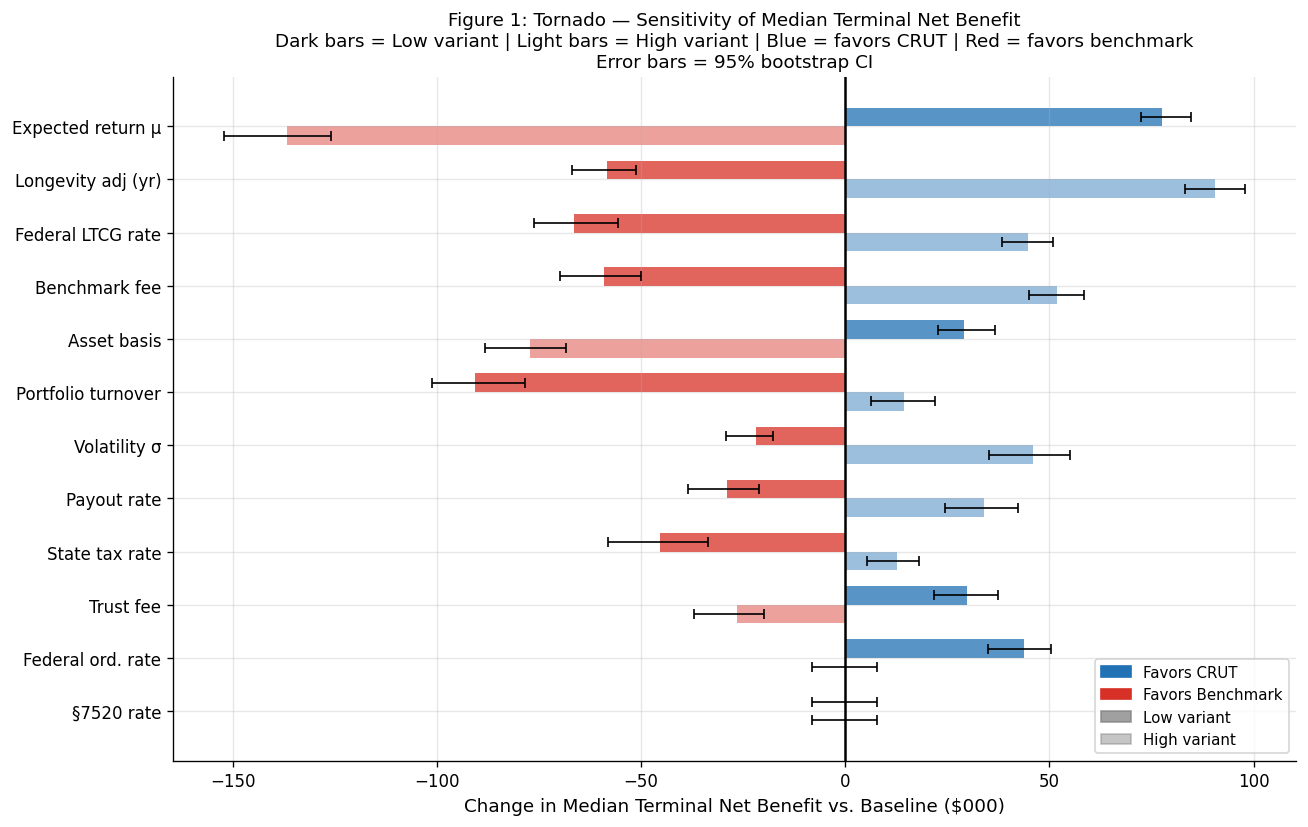

Figure 1 saved.


In [5]:
# --- Figure 1: Tornado — Median Terminal Net Benefit ---

labels = [v[0] for v in OAT_VARIANTS]

# Delta from baseline for each variant
med_lo = np.array([results_low[l]['median_delta']  - BASE_MED for l in labels])
med_hi = np.array([results_high[l]['median_delta'] - BASE_MED for l in labels])

# Bootstrap CIs on median delta for each variant
ci_lo_lo, ci_lo_hi, ci_hi_lo, ci_hi_hi = [], [], [], []
for l in labels:
    d_lo = results_low[l]['delta_wealth']
    d_hi = results_high[l]['delta_wealth']
    lo1, hi1 = bootstrap_ci(d_lo, np.median)
    lo2, hi2 = bootstrap_ci(d_hi, np.median)
    ci_lo_lo.append(lo1 - BASE_MED); ci_lo_hi.append(hi1 - BASE_MED)
    ci_hi_lo.append(lo2 - BASE_MED); ci_hi_hi.append(hi2 - BASE_MED)

# Sort by total influence (range)
total_range = np.abs(med_hi - med_lo)
sort_idx = np.argsort(total_range)

sorted_labels = [labels[i] for i in sort_idx]
sorted_lo  = med_lo[sort_idx]
sorted_hi  = med_hi[sort_idx]
err_lo = [(med_lo[i] - ci_lo_lo[i], ci_lo_hi[i] - med_lo[i]) for i in sort_idx]
err_hi = [(med_hi[i] - ci_hi_lo[i], ci_hi_hi[i] - med_hi[i]) for i in sort_idx]

fig, ax = plt.subplots(figsize=(11, 7))
y = np.arange(len(sorted_labels))
bar_h = 0.35

for i, (lo_val, hi_val, label, el, eh) in enumerate(
        zip(sorted_lo, sorted_hi, sorted_labels, err_lo, err_hi)):

    # Low bar
    color_lo = '#d73027' if lo_val < 0 else '#2171b5'
    ax.barh(y[i] + bar_h/2, lo_val/1000, height=bar_h,
            color=color_lo, alpha=0.75)
    ax.errorbar(lo_val/1000, y[i] + bar_h/2,
                xerr=[[el[0]/1000], [el[1]/1000]],
                fmt='none', color='black', capsize=3, lw=1)

    # High bar
    color_hi = '#d73027' if hi_val < 0 else '#2171b5'
    ax.barh(y[i] - bar_h/2, hi_val/1000, height=bar_h,
            color=color_hi, alpha=0.45)
    ax.errorbar(hi_val/1000, y[i] - bar_h/2,
                xerr=[[eh[0]/1000], [eh[1]/1000]],
                fmt='none', color='black', capsize=3, lw=1)

ax.axvline(0, color='black', lw=1.5)
ax.set_yticks(y)
ax.set_yticklabels(sorted_labels, fontsize=10)
ax.set_xlabel('Change in Median Terminal Net Benefit vs. Baseline ($000)', fontsize=11)
ax.set_title(
    'Figure 1: Tornado — Sensitivity of Median Terminal Net Benefit\n'
    'Dark bars = Low variant | Light bars = High variant | '
    'Blue = favors CRUT | Red = favors benchmark\n'
    'Error bars = 95% bootstrap CI',
    fontsize=11
)

blue_patch = mpatches.Patch(color='#2171b5', label='Favors CRUT')
red_patch  = mpatches.Patch(color='#d73027', label='Favors Benchmark')
dark_patch = mpatches.Patch(color='gray', alpha=0.75, label='Low variant')
lite_patch = mpatches.Patch(color='gray', alpha=0.45, label='High variant')
ax.legend(handles=[blue_patch, red_patch, dark_patch, lite_patch],
          fontsize=9, loc='lower right')

plt.tight_layout()
plt.savefig('fig1_tornado_median.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure 1 saved.')

### Figure 2: Tornado — Win Probability

This companion diagram shows the same OAT variants but evaluated using **win probability** rather than median net benefit. Win probability is a more decision-relevant metric for financial planners — it directly answers "how likely is the CRUT to outperform in this client's situation?"

**Why both metrics?** Median net benefit captures the magnitude of the advantage; win probability captures the reliability of the advantage. A parameter that produces a large median benefit but wide variance may have a lower win probability than one with a smaller but more consistent advantage. Reviewing both diagrams together reveals whether the ranking of influential parameters is consistent across metrics.

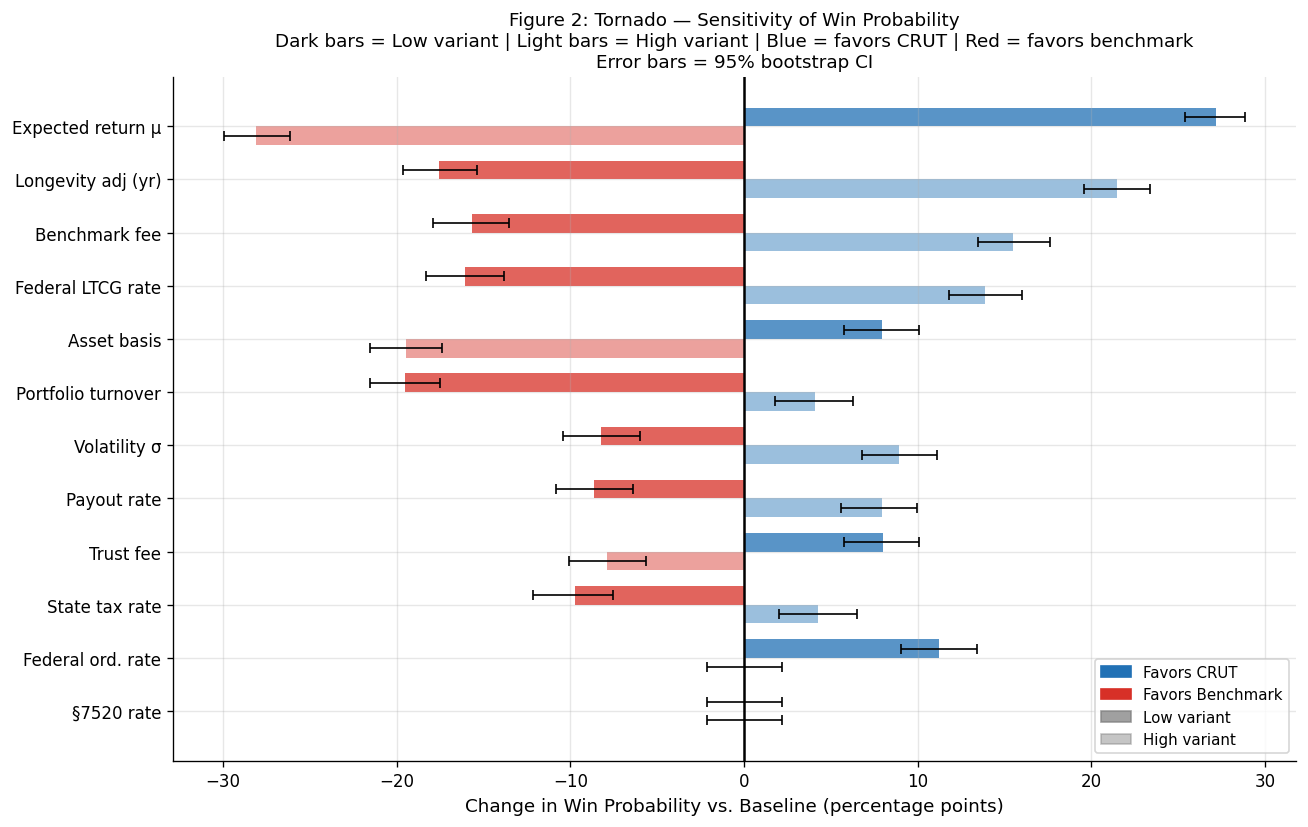

Figure 2 saved.


In [6]:
# --- Figure 2: Tornado — Win Probability ---

wp_lo = np.array([results_low[l]['win_prob']  - BASE_WIN for l in labels])
wp_hi = np.array([results_high[l]['win_prob'] - BASE_WIN for l in labels])

# Bootstrap CIs on win probability
wci_lo_lo, wci_lo_hi, wci_hi_lo, wci_hi_hi = [], [], [], []
for l in labels:
    d_lo = results_low[l]['delta_wealth']
    d_hi = results_high[l]['delta_wealth']
    lo1, hi1 = bootstrap_ci(d_lo, lambda x: np.mean(x > 0))
    lo2, hi2 = bootstrap_ci(d_hi, lambda x: np.mean(x > 0))
    wci_lo_lo.append(lo1 - BASE_WIN); wci_lo_hi.append(hi1 - BASE_WIN)
    wci_hi_lo.append(lo2 - BASE_WIN); wci_hi_hi.append(hi2 - BASE_WIN)

wp_range = np.abs(wp_hi - wp_lo)
sort_idx2 = np.argsort(wp_range)

sorted_labels2 = [labels[i] for i in sort_idx2]
s_wp_lo = wp_lo[sort_idx2]
s_wp_hi = wp_hi[sort_idx2]
werr_lo = [(wp_lo[i] - wci_lo_lo[i], wci_lo_hi[i] - wp_lo[i]) for i in sort_idx2]
werr_hi = [(wp_hi[i] - wci_hi_lo[i], wci_hi_hi[i] - wp_hi[i]) for i in sort_idx2]

fig, ax = plt.subplots(figsize=(11, 7))
y2 = np.arange(len(sorted_labels2))

for i, (lo_val, hi_val, label, el, eh) in enumerate(
        zip(s_wp_lo, s_wp_hi, sorted_labels2, werr_lo, werr_hi)):

    color_lo = '#d73027' if lo_val < 0 else '#2171b5'
    ax.barh(y2[i] + bar_h/2, lo_val * 100, height=bar_h,
            color=color_lo, alpha=0.75)
    ax.errorbar(lo_val*100, y2[i] + bar_h/2,
                xerr=[[el[0]*100], [el[1]*100]],
                fmt='none', color='black', capsize=3, lw=1)

    color_hi = '#d73027' if hi_val < 0 else '#2171b5'
    ax.barh(y2[i] - bar_h/2, hi_val * 100, height=bar_h,
            color=color_hi, alpha=0.45)
    ax.errorbar(hi_val*100, y2[i] - bar_h/2,
                xerr=[[eh[0]*100], [eh[1]*100]],
                fmt='none', color='black', capsize=3, lw=1)

ax.axvline(0, color='black', lw=1.5)
ax.set_yticks(y2)
ax.set_yticklabels(sorted_labels2, fontsize=10)
ax.set_xlabel('Change in Win Probability vs. Baseline (percentage points)', fontsize=11)
ax.set_title(
    'Figure 2: Tornado — Sensitivity of Win Probability\n'
    'Dark bars = Low variant | Light bars = High variant | '
    'Blue = favors CRUT | Red = favors benchmark\n'
    'Error bars = 95% bootstrap CI',
    fontsize=11
)
ax.legend(handles=[blue_patch, red_patch, dark_patch, lite_patch],
          fontsize=9, loc='lower right')

plt.tight_layout()
plt.savefig('fig2_tornado_winprob.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure 2 saved.')

---
## Section 3 — Detailed OAT Sweeps

The tornado diagrams provide a single Low/High comparison for each parameter. The following sweeps examine how win probability evolves *continuously* across the full range of each key parameter. This reveals whether effects are linear or exhibit threshold behavior — information that is obscured by the two-point OAT design.

Parameters chosen for detailed sweeps: turnover, fees, expected return, and payout rate. These were selected because they represent **controllable planning variables** — the planner or client can influence these choices — as distinct from market or regulatory parameters that are externally determined.

**Note on basis and longevity sweeps:** These are the subject of Notebooks 02 and 03 respectively, where they receive more thorough treatment.

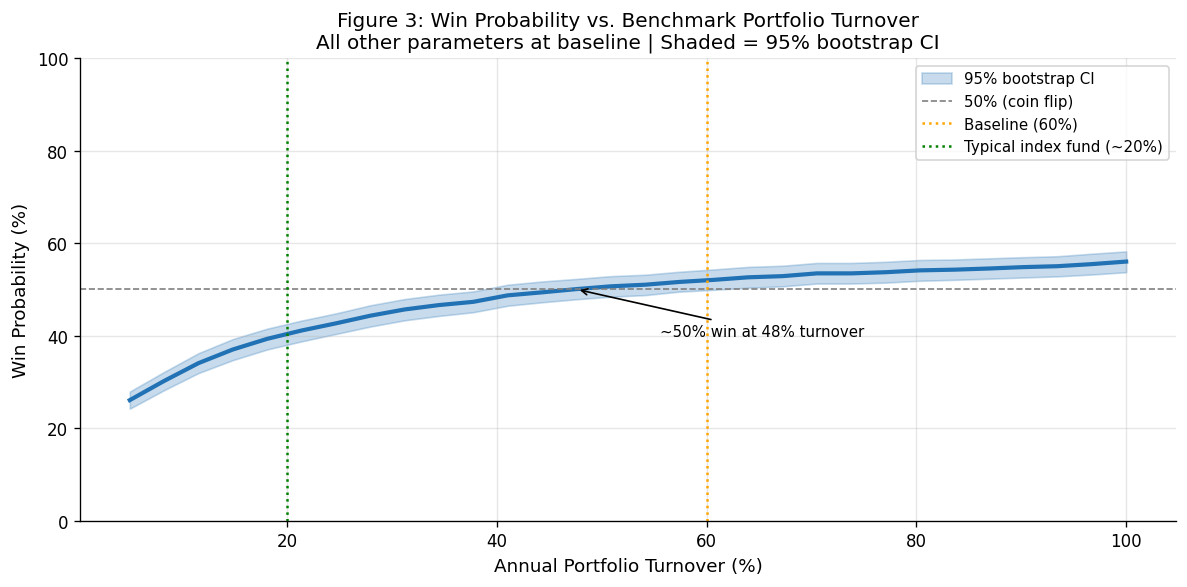

Figure 3 saved.
Win probability at 10% turnover: 26.1%
Win probability at 60% turnover: 50.0%
Win probability at 100% turnover: 56.0%


In [7]:
# --- Figure 3: Portfolio Turnover vs. Win Probability ---
# The reviewer flagged 60% turnover as high. This sweep shows the full picture
# from near-passive (10%) through aggressive active (100%).

turnover_vals = np.linspace(0.05, 1.00, 30)
wp_turnover   = []
ci_turnover   = []

from dataclasses import replace

for tv in turnover_vals:
    r = run_simulation(replace(baseline, turnover=tv))
    wp_turnover.append(r['win_prob'])
    lo, hi = bootstrap_ci(r['delta_wealth'], lambda x: np.mean(x > 0))
    ci_turnover.append((lo, hi))

wp_turnover = np.array(wp_turnover)
ci_lo_t = np.array([c[0] for c in ci_turnover])
ci_hi_t = np.array([c[1] for c in ci_turnover])

fig, ax = plt.subplots(figsize=(10, 5))
ax.fill_between(turnover_vals * 100, ci_lo_t * 100, ci_hi_t * 100,
                alpha=0.25, color='#2171b5', label='95% bootstrap CI')
ax.plot(turnover_vals * 100, wp_turnover * 100, color='#2171b5', lw=2.5)
ax.axhline(50, color='gray', ls='--', lw=1, label='50% (coin flip)')
ax.axvline(60, color='orange', ls=':', lw=1.5, label='Baseline (60%)')
ax.axvline(20, color='green',  ls=':', lw=1.5, label='Typical index fund (~20%)')

ax.set_xlabel('Annual Portfolio Turnover (%)', fontsize=11)
ax.set_ylabel('Win Probability (%)', fontsize=11)
ax.set_title(
    'Figure 3: Win Probability vs. Benchmark Portfolio Turnover\n'
    'All other parameters at baseline | Shaded = 95% bootstrap CI',
    fontsize=12
)
ax.legend(fontsize=9)
ax.set_ylim(0, 100)

# Annotation: find crossover point near 50%
cross_idx = np.argmin(np.abs(wp_turnover - 0.50))
cross_tv  = turnover_vals[cross_idx] * 100
ax.annotate(f'~50% win at {cross_tv:.0f}% turnover',
            xy=(cross_tv, 50), xytext=(cross_tv + 8, 40),
            arrowprops=dict(arrowstyle='->', color='black'),
            fontsize=9)

plt.tight_layout()
plt.savefig('fig3_turnover_sweep.png', bbox_inches='tight', dpi=150)
plt.show()
print(f'Figure 3 saved.')
print(f'Win probability at 10% turnover: {wp_turnover[0]:.1%}')
print(f'Win probability at 60% turnover: {wp_turnover[cross_idx]:.1%}')
print(f'Win probability at 100% turnover: {wp_turnover[-1]:.1%}')

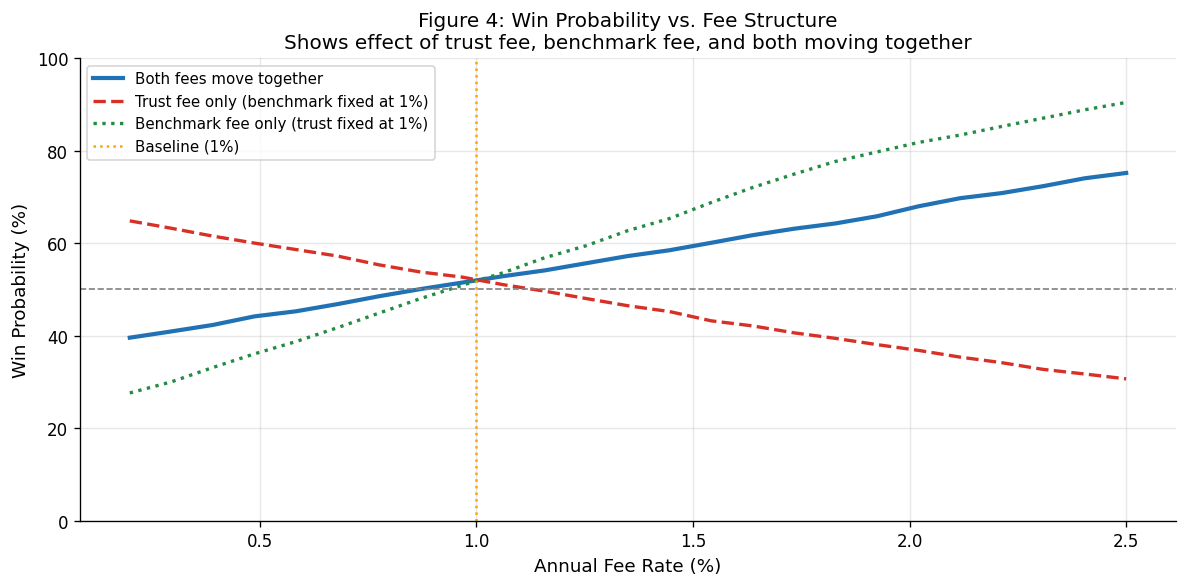

Figure 4 saved.


In [8]:
# --- Figure 4: Fee Drag vs. Win Probability ---
# Varies both trust fee and benchmark fee together (assuming fee parity)
# and separately (trust fee only, benchmark fee only).
# This reveals whether fee advantage or disadvantage matters more.

fee_vals = np.linspace(0.002, 0.025, 25)
wp_both, wp_trust_only, wp_bench_only = [], [], []

for fv in fee_vals:
    r1 = run_simulation(replace(baseline, trust_fee=fv, bench_fee=fv))
    r2 = run_simulation(replace(baseline, trust_fee=fv))
    r3 = run_simulation(replace(baseline, bench_fee=fv))
    wp_both.append(r1['win_prob'])
    wp_trust_only.append(r2['win_prob'])
    wp_bench_only.append(r3['win_prob'])

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(fee_vals * 100, np.array(wp_both)       * 100, color='#2171b5',
        lw=2.5, label='Both fees move together')
ax.plot(fee_vals * 100, np.array(wp_trust_only) * 100, color='#d73027',
        lw=2.0, ls='--', label='Trust fee only (benchmark fixed at 1%)')
ax.plot(fee_vals * 100, np.array(wp_bench_only) * 100, color='#238b45',
        lw=2.0, ls=':', label='Benchmark fee only (trust fixed at 1%)')
ax.axhline(50, color='gray', ls='--', lw=1)
ax.axvline(1.0, color='orange', ls=':', lw=1.5, label='Baseline (1%)')

ax.set_xlabel('Annual Fee Rate (%)', fontsize=11)
ax.set_ylabel('Win Probability (%)', fontsize=11)
ax.set_title(
    'Figure 4: Win Probability vs. Fee Structure\n'
    'Shows effect of trust fee, benchmark fee, and both moving together',
    fontsize=12
)
ax.legend(fontsize=9)
ax.set_ylim(0, 100)
plt.tight_layout()
plt.savefig('fig4_fee_sweep.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure 4 saved.')

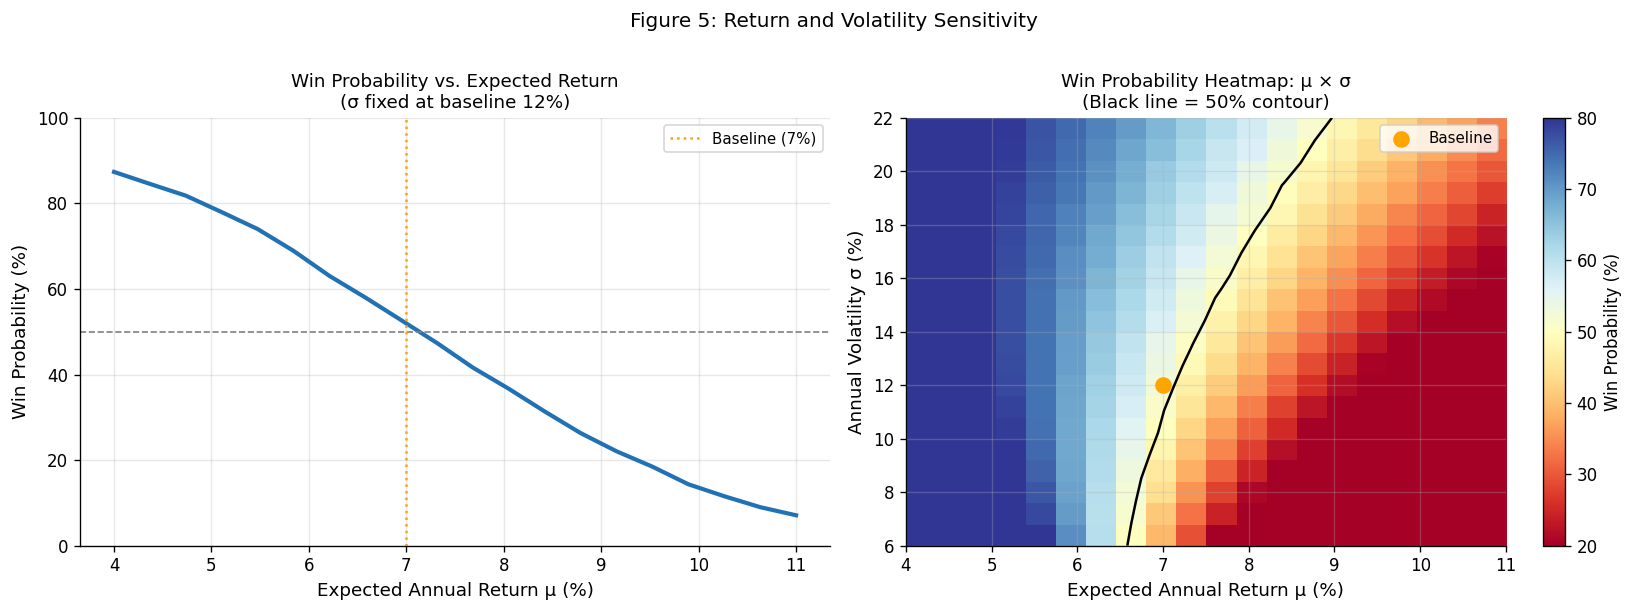

Figure 5 saved.


In [9]:
# --- Figure 5: Expected Return vs. Win Probability ---
# Also varies volatility, producing a 2D heatmap.

mu_vals    = np.linspace(0.04, 0.11, 20)
sigma_vals = np.linspace(0.06, 0.22, 20)

# Line plot: mu sweep at baseline sigma
wp_mu = [run_simulation(replace(baseline, mu=m))['win_prob'] for m in mu_vals]

# Heatmap: mu x sigma grid
heatmap = np.zeros((len(sigma_vals), len(mu_vals)))
for i, s in enumerate(sigma_vals):
    for j, m in enumerate(mu_vals):
        heatmap[i, j] = run_simulation(replace(baseline, mu=m, sigma=s))['win_prob']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: line plot
axes[0].plot(mu_vals * 100, np.array(wp_mu) * 100, color='#2171b5', lw=2.5)
axes[0].axhline(50, color='gray', ls='--', lw=1)
axes[0].axvline(7, color='orange', ls=':', lw=1.5, label='Baseline (7%)')
axes[0].set_xlabel('Expected Annual Return μ (%)', fontsize=11)
axes[0].set_ylabel('Win Probability (%)', fontsize=11)
axes[0].set_title('Win Probability vs. Expected Return\n(σ fixed at baseline 12%)', fontsize=11)
axes[0].legend(fontsize=9)
axes[0].set_ylim(0, 100)

# Right: heatmap
im = axes[1].imshow(
    heatmap * 100, origin='lower', aspect='auto',
    extent=[mu_vals[0]*100, mu_vals[-1]*100,
            sigma_vals[0]*100, sigma_vals[-1]*100],
    cmap='RdYlBu', vmin=20, vmax=80
)
plt.colorbar(im, ax=axes[1], label='Win Probability (%)')
axes[1].scatter([7], [12], color='orange', s=80, zorder=5, label='Baseline')
# Draw 50% contour
mu_grid, sigma_grid = np.meshgrid(mu_vals * 100, sigma_vals * 100)
axes[1].contour(mu_grid, sigma_grid, heatmap * 100, levels=[50],
                colors='black', linewidths=1.5)
axes[1].set_xlabel('Expected Annual Return μ (%)', fontsize=11)
axes[1].set_ylabel('Annual Volatility σ (%)', fontsize=11)
axes[1].set_title('Win Probability Heatmap: μ × σ\n(Black line = 50% contour)', fontsize=11)
axes[1].legend(fontsize=9)

fig.suptitle('Figure 5: Return and Volatility Sensitivity', fontsize=12, y=1.01)
plt.tight_layout()
plt.savefig('fig5_return_sweep.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure 5 saved.')

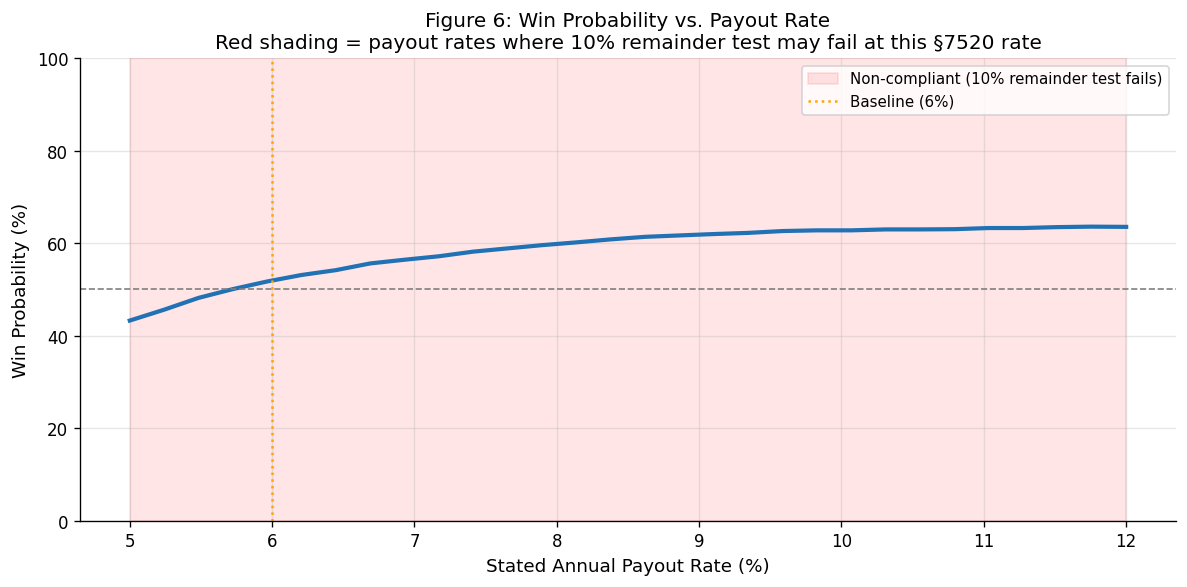

Figure 6 saved.


In [10]:
# --- Figure 6: Payout Rate vs. Win Probability ---
# Payout rate affects both the annual income and the trust corpus growth.
# Higher payout = more income but faster depletion of corpus.
# Must remain compliant with 10% remainder test.

payout_vals = np.linspace(0.05, 0.12, 30)
wp_payout, compliance_payout = [], []

for pv in payout_vals:
    r = run_simulation(replace(baseline, payout_rate=pv))
    wp_payout.append(r['win_prob'])
    compliance_payout.append(r['deduction_res']['compliance'])

wp_payout = np.array(wp_payout)
compliance_payout = np.array(compliance_payout)

fig, ax = plt.subplots(figsize=(10, 5))

# Shade non-compliant region
first_noncompliant = payout_vals[~compliance_payout]
if len(first_noncompliant) > 0:
    nc_threshold = first_noncompliant[0]
    ax.axvspan(nc_threshold * 100, payout_vals[-1] * 100,
               alpha=0.10, color='red', label='Non-compliant (10% remainder test fails)')

ax.plot(payout_vals * 100, wp_payout * 100, color='#2171b5', lw=2.5)
ax.axhline(50, color='gray', ls='--', lw=1)
ax.axvline(6, color='orange', ls=':', lw=1.5, label='Baseline (6%)')

ax.set_xlabel('Stated Annual Payout Rate (%)', fontsize=11)
ax.set_ylabel('Win Probability (%)', fontsize=11)
ax.set_title(
    'Figure 6: Win Probability vs. Payout Rate\n'
    'Red shading = payout rates where 10% remainder test may fail at this §7520 rate',
    fontsize=12
)
ax.legend(fontsize=9)
ax.set_ylim(0, 100)
plt.tight_layout()
plt.savefig('fig6_payout_sweep.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure 6 saved.')

---
## Section 4 — Asymmetry Analysis

### Figure 7: Loss Magnitude vs. Gain Magnitude

The baseline distribution in Notebook 00 (Figure 3) revealed an important asymmetry: when the benchmark wins, it tends to win by more than when the CRUT wins. This is a materially important finding for financial planners — it means the CRUT's 51.9% win probability may overstate its attractiveness from a risk-adjusted perspective.

This figure quantifies that asymmetry across all OAT variants, asking: for each parameter setting, what is the median gain when the CRUT wins, versus the median loss when it loses?

A point above the diagonal means the CRUT tends to win big when it wins (favorable); a point below the diagonal means it loses big when it loses (unfavorable). **This chart does not appear in the manuscript and is provided here as an additional diagnostic for practitioners.**

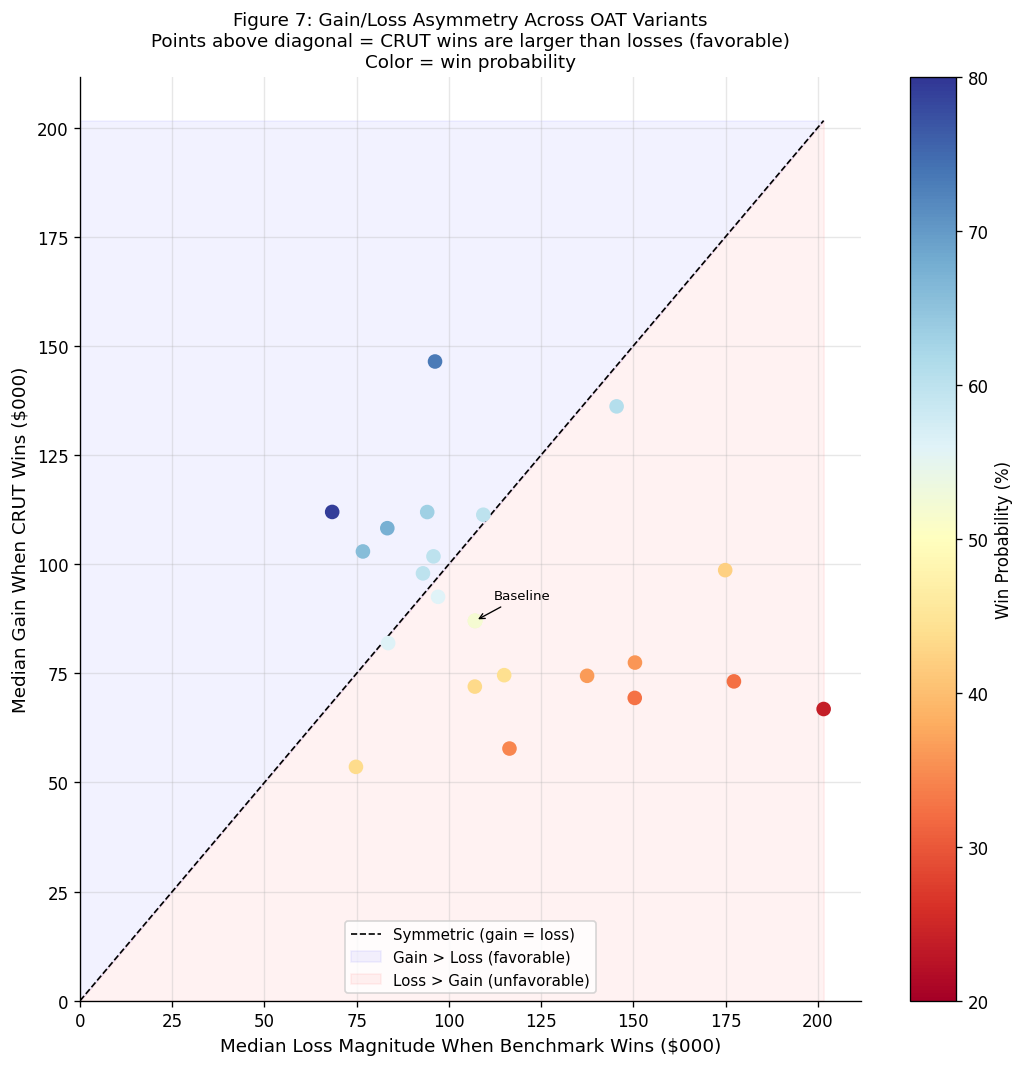

Figure 7 saved.


In [11]:
# --- Figure 7: Asymmetry — median gain vs. median loss magnitude ---

def gain_loss_stats(delta):
    """Return median gain when CRUT wins, median loss magnitude when it loses."""
    wins  = delta[delta > 0]
    loses = delta[delta <= 0]
    med_gain = np.median(wins)  if len(wins)  > 0 else 0
    med_loss = np.median(np.abs(loses)) if len(loses) > 0 else 0
    return med_gain, med_loss

all_gains, all_losses, all_labels_asym, all_wps = [], [], [], []

# Baseline
g, l = gain_loss_stats(base_results['delta_wealth'])
all_gains.append(g/1000); all_losses.append(l/1000)
all_labels_asym.append('Baseline'); all_wps.append(BASE_WIN)

for label, field_name, low_val, high_val in OAT_VARIANTS:
    for val, suffix in [(low_val, ' (Lo)'), (high_val, ' (Hi)')]:
        r = run_variant(field_name, val)
        g, l = gain_loss_stats(r['delta_wealth'])
        all_gains.append(g/1000); all_losses.append(l/1000)
        all_labels_asym.append(label + suffix)
        all_wps.append(r['win_prob'])

all_gains  = np.array(all_gains)
all_losses = np.array(all_losses)
all_wps    = np.array(all_wps)

fig, ax = plt.subplots(figsize=(9, 9))

sc = ax.scatter(all_losses, all_gains, c=all_wps * 100,
                cmap='RdYlBu', s=60, vmin=20, vmax=80, zorder=3)
plt.colorbar(sc, ax=ax, label='Win Probability (%)')

# Diagonal = symmetric gains/losses
max_val = max(all_gains.max(), all_losses.max())
ax.plot([0, max_val], [0, max_val], 'k--', lw=1, label='Symmetric (gain = loss)')

# Label baseline
ax.annotate('Baseline', xy=(all_losses[0], all_gains[0]),
            xytext=(all_losses[0]+5, all_gains[0]+5), fontsize=8,
            arrowprops=dict(arrowstyle='->', color='black', lw=0.8))

ax.fill_between([0, max_val], [0, max_val], [max_val, max_val],
                alpha=0.05, color='blue', label='Gain > Loss (favorable)')
ax.fill_between([0, max_val], [0, 0], [0, max_val],
                alpha=0.05, color='red', label='Loss > Gain (unfavorable)')

ax.set_xlabel('Median Loss Magnitude When Benchmark Wins ($000)', fontsize=11)
ax.set_ylabel('Median Gain When CRUT Wins ($000)', fontsize=11)
ax.set_title(
    'Figure 7: Gain/Loss Asymmetry Across OAT Variants\n'
    'Points above diagonal = CRUT wins are larger than losses (favorable)\n'
    'Color = win probability',
    fontsize=11
)
ax.legend(fontsize=9)
ax.set_xlim(0); ax.set_ylim(0)
plt.tight_layout()
plt.savefig('fig7_asymmetry.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure 7 saved.')

---
## Section 5 — Summary Table and Findings

The table below ranks all OAT variants by their influence on win probability, providing a single reference for the key sensitivity findings. This table supports the manuscript's discussion section.

In [12]:
# Summary table: all variants ranked by win probability range

print(f"{'Parameter':<28} {'Low val':>8} {'WP(Lo)':>8} {'Base':>8} {'WP(Hi)':>8} {'High val':>9} {'Range pp':>9}")
print('-' * 88)

summary_rows = []
for label, field_name, low_val, high_val in OAT_VARIANTS:
    wp_lo_val = results_low[label]['win_prob']
    wp_hi_val = results_high[label]['win_prob']
    rng = abs(wp_hi_val - wp_lo_val) * 100
    summary_rows.append((rng, label, low_val, high_val, wp_lo_val, wp_hi_val))

summary_rows.sort(reverse=True)

for rng, label, low_val, high_val, wp_lo_val, wp_hi_val in summary_rows:
    # Format low/high value: longevity is in years, others are rates
    rate_params = {'basis_pct', 'turnover', 'trust_fee', 'bench_fee',
                   'fed_ordinary', 'fed_ltcg', 'state_rate', 'payout_rate',
                   'mu', 'sigma', 'rate_7520'}
    field_name = next(f for l, f, lv, hv in OAT_VARIANTS if l == label)
    if field_name in rate_params:
        lo_str = f'{low_val*100:.1f}%'
        hi_str = f'{high_val*100:.1f}%'
    else:
        lo_str = f'{low_val:+.0f} yr'
        hi_str = f'{high_val:+.0f} yr'
    print(f"{label:<28} {lo_str:>9}  {wp_lo_val*100:>6.1f}%  "
          f"{BASE_WIN*100:>6.1f}%  {wp_hi_val*100:>6.1f}%  "
          f"{hi_str:>9}  {rng:>8.1f}pp")

print()
print('Key findings:')
top3 = summary_rows[:3]
print(f'  Most influential parameters (by win probability range):')
for i, (rng, label, *_) in enumerate(top3):
    print(f'    {i+1}. {label} ({rng:.1f} pp range)')
print()

# Find §7520 rate rank
for rank, (rng, label, *_) in enumerate(summary_rows, 1):
    if '7520' in label:
        print(f'  §7520 rate ranks #{rank} of {len(summary_rows)} parameters ({rng:.1f} pp range)')
        print(f'  This confirms the manuscript finding: §7520 rate has limited')
        print(f'  influence on CRUT economic performance, despite its centrality')
        print(f'  to deduction compliance under IRC §7520.')
        break

Parameter                     Low val   WP(Lo)     Base   WP(Hi)  High val  Range pp
----------------------------------------------------------------------------------------
Expected return μ                 5.0%    79.1%    51.9%    23.8%       9.0%      55.3pp
Longevity adj (yr)               -5 yr    34.4%    51.9%    73.4%     +10 yr      39.0pp
Benchmark fee                     0.5%    36.2%    51.9%    67.4%       1.5%      31.2pp
Federal LTCG rate                15.0%    35.9%    51.9%    65.8%      23.8%      29.9pp
Asset basis                       5.0%    59.9%    51.9%    32.5%      60.0%      27.4pp
Portfolio turnover               10.0%    32.4%    51.9%    56.0%     100.0%      23.6pp
Volatility σ                      8.0%    43.6%    51.9%    60.9%      18.0%      17.2pp
Payout rate                       5.0%    43.2%    51.9%    59.9%       8.0%      16.6pp
Trust fee                         0.5%    59.9%    51.9%    44.0%       1.5%      15.9pp
State tax rate           

---
## Section 6 — Why Does Expected Return Rank #1? A Decomposition

The sensitivity table shows expected return μ as the most influential parameter (55.3pp range), with **high returns favoring the benchmark** (win probability falls from 79.1% at μ=5% to 23.8% at μ=9%). This is counterintuitive at first glance — one might expect a better-performing portfolio to benefit both strategies equally.

### Economic Explanation

The effect is real and arises from a structural asymmetry between the two strategies:

**The CRUT pays out 6% of the annually revalued corpus each year.** In high-return environments, the corpus grows rapidly — but so do the mandatory distributions, which leave the trust and are taxed as ordinary income. The *net* corpus remaining in the trust grows more slowly than the benchmark portfolio, which retains and compounds its full value.

**The benchmark benefits disproportionately from high returns** because it compounds on its full corpus. The CRUT's structural tax advantages (deduction benefit, deferred capital gains recognition) are fixed at inception and do not scale with realized market returns. The benchmark's tax friction (turnover drag, LTCG on gains) does scale with returns — but at high return levels, the gross compounding advantage of the full corpus more than offsets the tax drag.

**At low returns, the CRUT's fixed tax advantages dominate.** When the benchmark is generating modest gross growth, the tax deduction benefit and deferred capital gains recognition represent a larger fraction of total economic value. The benchmark's turnover-driven tax drag remains proportional to (modest) gains, while the CRUT's deduction benefit was computed at inception and is unaffected by subsequent market performance.

**Practical implication for planners:** This finding suggests that CRUT recommendations should be more aggressive in lower-return environments or for clients with conservative portfolios. It also means that the common practitioner assumption — that CRUTs become more attractive in bull markets because of higher distributions — is partially incorrect. Higher distributions come at the cost of corpus depletion, and in strong bull markets the benchmark's compounding advantage offsets the CRUT's structural benefits.

**The decomposition figure below** separates the CRUT's economic benefit into three components across the return spectrum, making this mechanism visually explicit.

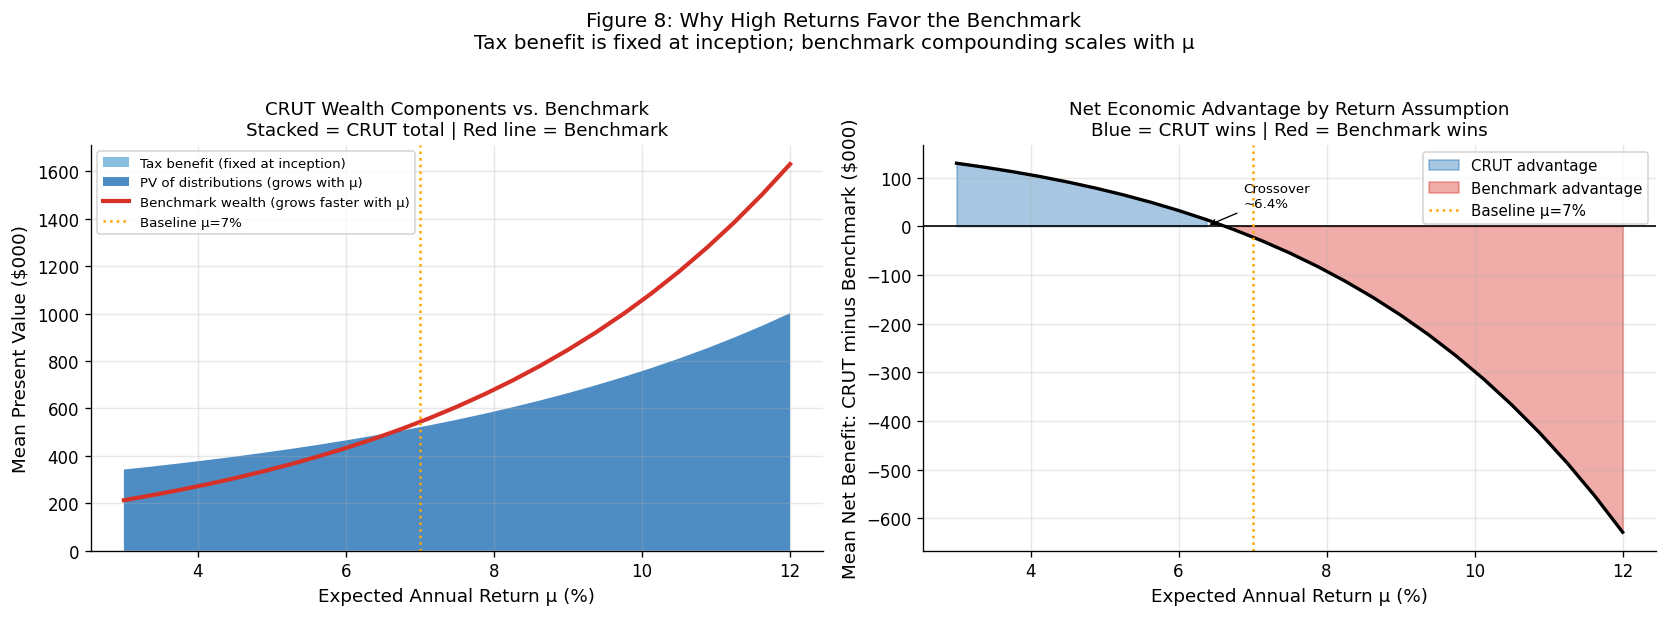

Figure 8 saved.

Key insight: The CRUT tax benefit is computed at inception using the
§7520 rate and actuarial tables — it does not grow with realized returns.
The benchmark, by contrast, compounds its full corpus at the realized
market rate. At high return assumptions, this compounding advantage
outweighs the CRUT structural benefits.

The mean net benefit crossover occurs near μ = 6.4%
Below this return assumption, the CRUT is expected to produce
greater mean wealth. Above it, the benchmark is expected to dominate.


In [13]:
# --- Figure 8: Return decomposition — what drives CRUT advantage at different μ? ---
# Decomposes CRUT personal wealth into:
#   (A) PV of tax benefit from charitable deduction
#   (B) PV of after-tax distributions
# And shows benchmark wealth alongside.
# This reveals WHY high returns favor the benchmark.

mu_vals_decomp = np.linspace(0.03, 0.12, 25)
pv_tax_benefits, pv_dists, bench_wealths, crut_wealths = [], [], [], []

for m in mu_vals_decomp:
    p = replace(baseline, mu=m)
    ded_res = compute_deduction(
        fmv=p.fmv, payout_rate=p.payout_rate, rate_7520=p.rate_7520,
        life_type=p.life_type, age1=p.age1, age2=p.age2,
        longevity_adj=p.longevity_adj,
    )
    T = int(round(ded_res['sim_horizon']))
    deduction = ded_res['deduction']
    combined_ordinary = p.fed_ordinary + p.state_rate
    annual_agi_limit = p.agi * p.agi_limit_pct
    remaining = deduction
    pv_tax = 0.0
    for yr in range(p.carryforward_years + 1):
        usable = min(remaining, annual_agi_limit)
        if usable <= 0:
            break
        pv_tax += usable * combined_ordinary / (1 + p.pv_rate) ** yr
        remaining -= usable
    returns = generate_return_paths(p.mu, p.sigma, T, p.n_paths, seed=p.seed)
    tau_ord = p.fed_ordinary + p.state_rate
    tau_cg  = p.fed_ltcg + p.niit + p.state_rate
    crut_v = np.full(p.n_paths, p.fmv)
    dists = np.zeros((p.n_paths, T))
    for t in range(T):
        v = crut_v * (1 - p.trust_fee) * returns[:, t]
        d = v * p.payout_rate
        dists[:, t] = d * (1 - tau_ord)
        crut_v = np.maximum(0, v - d)
    bench_v = np.full(p.n_paths, p.fmv)
    bench_basis = p.fmv * p.basis_pct
    for t in range(T):
        b = bench_v * (1 - p.bench_fee) * returns[:, t]
        gain = np.maximum(0, b - bench_basis)
        tax_drag = p.turnover * gain * tau_cg
        bench_v = np.maximum(0, b - tax_drag)
        bench_basis = bench_basis + p.turnover * gain * (1 - tau_cg)
    discount_factors = np.array([(1 + p.pv_rate) ** -(t+1) for t in range(T)])
    pv_d = (dists * discount_factors[np.newaxis, :]).sum(axis=1)
    terminal_gain = np.maximum(0, bench_v - bench_basis)
    bw = (bench_v - terminal_gain * tau_cg) / (1 + p.pv_rate) ** T
    pv_tax_benefits.append(pv_tax)
    pv_dists.append(np.mean(pv_d))
    bench_wealths.append(np.mean(bw))
    crut_wealths.append(np.mean(pv_d) + pv_tax)

pv_tax_benefits = np.array(pv_tax_benefits) / 1000
pv_dists        = np.array(pv_dists)        / 1000
bench_wealths   = np.array(bench_wealths)   / 1000
crut_wealths    = np.array(crut_wealths)    / 1000
mu_pct = mu_vals_decomp * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: stacked area — CRUT components vs. benchmark
ax = axes[0]
ax.stackplot(mu_pct,
             [pv_tax_benefits, pv_dists],
             labels=['Tax benefit (fixed at inception)', 'PV of distributions (grows with μ)'],
             colors=['#6baed6', '#2171b5'], alpha=0.8)
ax.plot(mu_pct, bench_wealths, color='#d73027', lw=2.5,
        label='Benchmark wealth (grows faster with μ)')
ax.axvline(7, color='orange', ls=':', lw=1.5, label='Baseline μ=7%')
ax.set_xlabel('Expected Annual Return μ (%)', fontsize=11)
ax.set_ylabel('Mean Present Value ($000)', fontsize=11)
ax.set_title('CRUT Wealth Components vs. Benchmark\n'
             'Stacked = CRUT total | Red line = Benchmark', fontsize=11)
ax.legend(fontsize=8, loc='upper left')

# Right: win probability and net benefit vs. mu
ax2 = axes[1]
net_benefit = crut_wealths - bench_wealths
color_pos = '#2171b5'
color_neg = '#d73027'
ax2.fill_between(mu_pct, 0, net_benefit,
                 where=net_benefit >= 0, alpha=0.4, color=color_pos,
                 label='CRUT advantage')
ax2.fill_between(mu_pct, 0, net_benefit,
                 where=net_benefit < 0, alpha=0.4, color=color_neg,
                 label='Benchmark advantage')
ax2.plot(mu_pct, net_benefit, color='black', lw=2)
ax2.axhline(0, color='black', lw=1)
ax2.axvline(7, color='orange', ls=':', lw=1.5, label='Baseline μ=7%')

# Find crossover
sign_changes = np.where(np.diff(np.sign(net_benefit)))[0]
for sc in sign_changes:
    cross_mu = mu_pct[sc]
    ax2.annotate(f'Crossover\n~{cross_mu:.1f}%',
                xy=(cross_mu, 0), xytext=(cross_mu+0.5, net_benefit.max()*0.3),
                arrowprops=dict(arrowstyle='->', color='black', lw=0.8),
                fontsize=8)

ax2.set_xlabel('Expected Annual Return μ (%)', fontsize=11)
ax2.set_ylabel('Mean Net Benefit: CRUT minus Benchmark ($000)', fontsize=11)
ax2.set_title('Net Economic Advantage by Return Assumption\n'
              'Blue = CRUT wins | Red = Benchmark wins', fontsize=11)
ax2.legend(fontsize=9)

fig.suptitle(
    'Figure 8: Why High Returns Favor the Benchmark\n'
    'Tax benefit is fixed at inception; benchmark compounding scales with μ',
    fontsize=12, y=1.02
)
plt.tight_layout()
plt.savefig('fig8_return_decomposition.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure 8 saved.')
print()
print('Key insight: The CRUT tax benefit is computed at inception using the')
print('§7520 rate and actuarial tables — it does not grow with realized returns.')
print('The benchmark, by contrast, compounds its full corpus at the realized')
print('market rate. At high return assumptions, this compounding advantage')
print('outweighs the CRUT structural benefits.')
print()
if len(sign_changes) > 0:
    print(f'The mean net benefit crossover occurs near μ = {mu_pct[sign_changes[0]]:.1f}%')
    print(f'Below this return assumption, the CRUT is expected to produce')
    print(f'greater mean wealth. Above it, the benchmark is expected to dominate.')

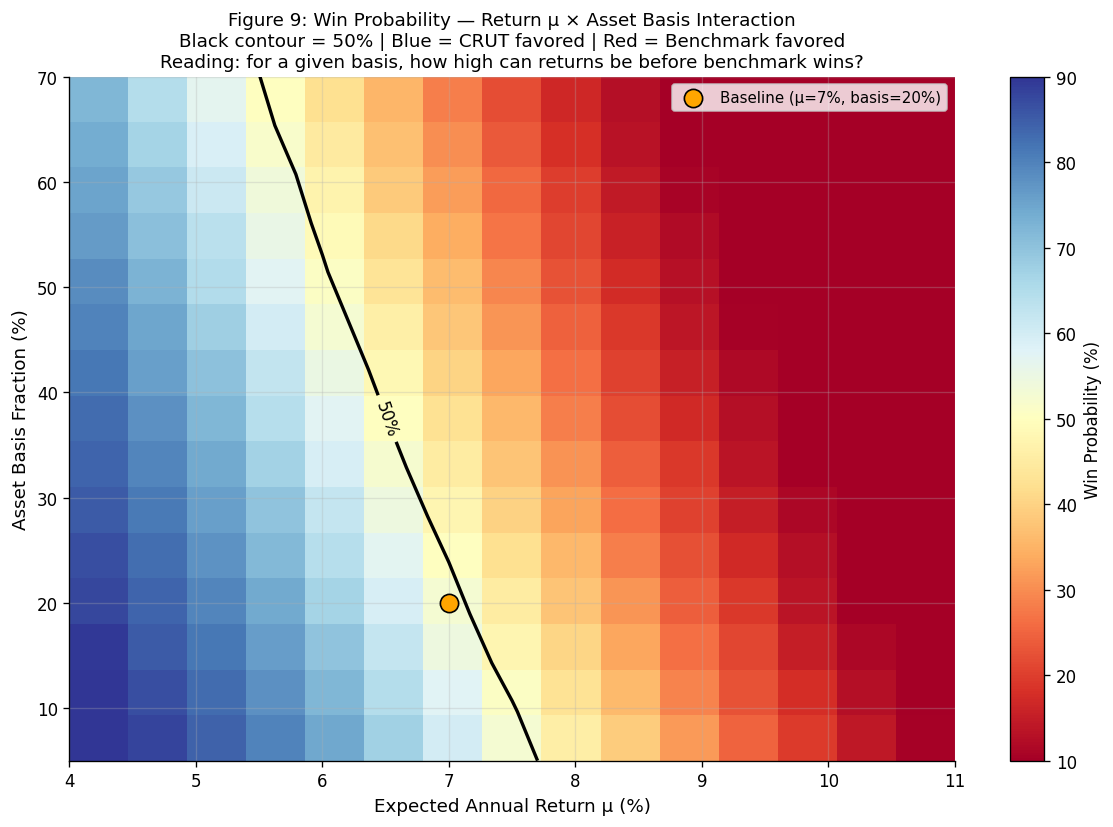

Figure 9 saved.

Reading this figure for planners:
  - Each row = a client with a specific basis fraction
  - Moving right along that row = assuming higher expected returns
  - The 50% contour is the breakeven line
  - Assets with very low basis remain CRUT-favorable across a wide
    range of return assumptions
  - As basis rises, only lower return environments favor the CRUT


In [14]:
# --- Figure 9: Interaction of expected return and asset basis ---
# Shows that the return sensitivity depends on basis.
# At very low basis, high returns still favor CRUT because the deduction
# is large enough to sustain the advantage even at high growth rates.

mu_grid_vals    = np.linspace(0.04, 0.11, 15)
basis_grid_vals = np.linspace(0.05, 0.70, 15)
heatmap_wb = np.zeros((len(basis_grid_vals), len(mu_grid_vals)))

for i, b in enumerate(basis_grid_vals):
    for j, m in enumerate(mu_grid_vals):
        r = run_simulation(replace(baseline, basis_pct=b, mu=m))
        heatmap_wb[i, j] = r['win_prob']

fig, ax = plt.subplots(figsize=(10, 7))
im = ax.imshow(
    heatmap_wb * 100, origin='lower', aspect='auto',
    extent=[mu_grid_vals[0]*100, mu_grid_vals[-1]*100,
            basis_grid_vals[0]*100, basis_grid_vals[-1]*100],
    cmap='RdYlBu', vmin=10, vmax=90
)
plt.colorbar(im, ax=ax, label='Win Probability (%)')

# 50% contour
mu_g, basis_g = np.meshgrid(mu_grid_vals*100, basis_grid_vals*100)
cs = ax.contour(mu_g, basis_g, heatmap_wb*100, levels=[50],
                colors='black', linewidths=2)
ax.clabel(cs, fmt='50%%', fontsize=10)

# Mark baseline
ax.scatter([7], [20], color='orange', s=120, zorder=5,
           label='Baseline (μ=7%, basis=20%)', edgecolors='black')

ax.set_xlabel('Expected Annual Return μ (%)', fontsize=11)
ax.set_ylabel('Asset Basis Fraction (%)', fontsize=11)
ax.set_title(
    'Figure 9: Win Probability — Return μ × Asset Basis Interaction\n'
    'Black contour = 50% | Blue = CRUT favored | Red = Benchmark favored\n'
    'Reading: for a given basis, how high can returns be before benchmark wins?',
    fontsize=11
)
ax.legend(fontsize=9)
plt.tight_layout()
plt.savefig('fig9_return_basis_interaction.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure 9 saved.')
print()
print('Reading this figure for planners:')
print('  - Each row = a client with a specific basis fraction')
print('  - Moving right along that row = assuming higher expected returns')
print('  - The 50% contour is the breakeven line')
print('  - Assets with very low basis remain CRUT-favorable across a wide')
print('    range of return assumptions')
print('  - As basis rises, only lower return environments favor the CRUT')

In [15]:
# Final completion check
import os
figures = [
    'fig1_tornado_median.png',
    'fig2_tornado_winprob.png',
    'fig3_turnover_sweep.png',
    'fig4_fee_sweep.png',
    'fig5_return_sweep.png',
    'fig6_payout_sweep.png',
    'fig7_asymmetry.png',
    'fig8_return_decomposition.png',
    'fig9_return_basis_interaction.png',
]
print('Notebook 01 — Sensitivity Analysis: completion check')
print('-' * 50)
for f in figures:
    print(f"  {'OK' if os.path.exists(f) else 'MISSING'} {f}")
print()
print(f'Baseline win probability:    {BASE_WIN:.1%}')
print(f'Baseline median net benefit: ${BASE_MED:,.0f}')
print()
print('Notebook 01 (revised) complete. Proceed to Notebook 02 — Asset Basis.')

Notebook 01 — Sensitivity Analysis: completion check
--------------------------------------------------
  OK fig1_tornado_median.png
  OK fig2_tornado_winprob.png
  OK fig3_turnover_sweep.png
  OK fig4_fee_sweep.png
  OK fig5_return_sweep.png
  OK fig6_payout_sweep.png
  OK fig7_asymmetry.png
  OK fig8_return_decomposition.png
  OK fig9_return_basis_interaction.png

Baseline win probability:    51.9%
Baseline median net benefit: $7,350

Notebook 01 (revised) complete. Proceed to Notebook 02 — Asset Basis.
